## Testing out iminuit fitting for FOM, will replace curve fit

In [89]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit

import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### load and prepare data

In [3]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/', '75_9e-3/PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = low_e_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)



Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Porting 75_9e-3/PORT_2b/isaura/
50
100
150
200
250
300
Tracks: 80864
Done! Tracks available: 259847


/tmp/ipykernel_12999/2704749952.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 39.84 %
Absolute Cut efficiency:
Efficiency: 39.84 %
One track cut
Relative Cut efficiency:
Efficiency: 64.26 %
Absolute Cut efficiency:
Efficiency: 52.09 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.74 %
Absolute Cut efficiency:
Efficiency: 72.42 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.60 %
Absolute Cut efficiency:
Efficiency: 7.88 %


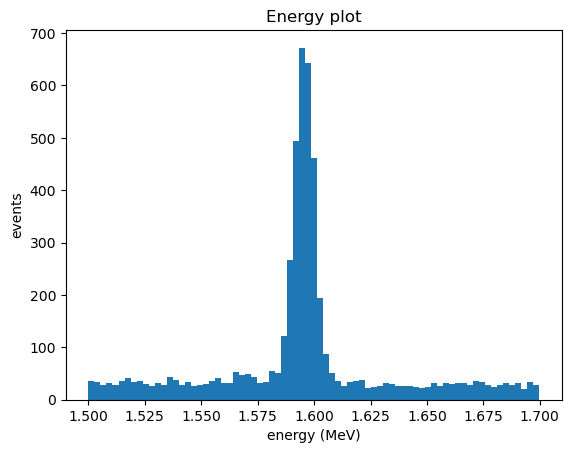

In [4]:
func.plot_hist(cut_tracks[0], binning = 75, log = False)

In [5]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976
Loading positrons from 75_9e-3/PORT_2b/isaura/
Positron events: 12817
Port finished! Tracks available: 47202


In [6]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

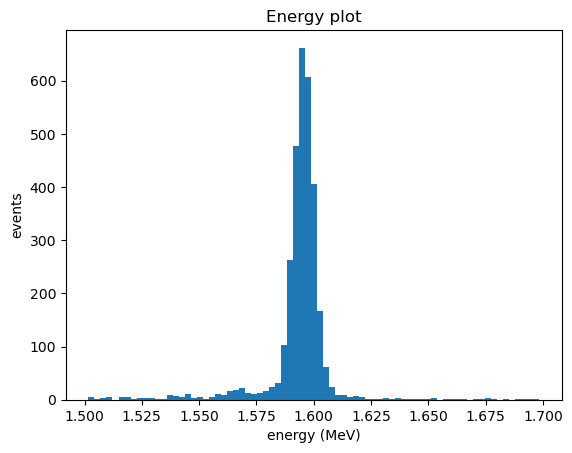

In [7]:
func.plot_hist(ecut_positron_df, binning = 75, log = False)

In [8]:
cut_list = np.linspace(0,0.6, 61)

# Fit
#fom_out_fit = func.fom_calc_MC(cut_tracks[0], pos_events, cut_list, binning = 60)

In [9]:
def fit(c, C1, C2, mu, sigma):
    m = Minuit(c, ns = 400, a = 1, nb = 20, tau = 0.1, C1 = C1, C2 = C2, mu = mu, sigma = sigma)
    m.fixed['mu'] = True
    m.fixed['sigma'] = True
    m.fixed['C1'] = True
    m.fixed['C2'] = True
    m.limits["ns", "nb"] = (0, None)
    m.migrad()
    assert m.valid
    return m

In [10]:
# create a distribution function for the bins
def integral(xe, ns, a, mu, sigma, C1, C2, nb, tau):

    return ns * skewnorm_func.cdf(x, a, mu, sigma) + C1 

### unbinned extended maximum likelihood fit for C1 C2 

In [11]:
# set range we're considering
fit_range = (1.5, 1.7)
binning = 80

In [69]:
def bck_func_no_N(x, tau):
    return np.exp(-x/tau)

def gauss_no_N(x, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return np.exp(-numer/denom)

In [82]:
# Normalise and extend
sig_norm = probfit.Normalized(func.sig_func_no_N, fit_range)
sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

bck_norm = probfit.Normalized(bck_func_no_N, fit_range)
bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

gauss_norm = probfit.Normalized(gauss_no_N, fit_range)
gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

In [15]:

e_s = ecut_positron_df['energy'].to_numpy()
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)



In [16]:
# minimise that mfer
m.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   0 - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   1 - FCN =  -31245.53859823 Edm =      4101.86 NCalls =     93
VariableMetric: Iteration #   2 - FCN =  -32701.34672537 Edm =      154.269 NCalls =    115
VariableMetric: Iteration #   3 - FCN =  -32748.75879748 Edm =      97.5243 NCalls =    129
VariableMetric: Iteration #   4 - FCN =  -32785.39340618 Edm =      6.77937 NCalls =    143
VariableMetric: Iteration #   5 - FCN =  -32789.28646603 Edm =      8.52043 NCalls =    157
VariableMetric: Iteration #   6 - FCN =  -32793.78683505 Edm =      1.10539 NCalls =    171
VariableMetric: Iteration #   7 - FCN =  -32801.06577986 Edm =       2.8386 NCalls =    187
VariableMetric: Iteration #   8 - FCN =  -32810.06312682 Edm =       3.7456 NCalls =    205
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -3.282e+04                 │        Nfcn = 410 (410 total)        │
│ EDM = 2.28e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

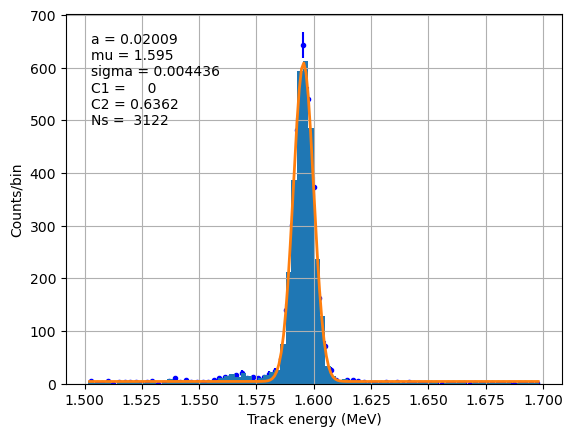

"\nC1_test = 1\nx_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE\ny_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)\nplt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))\nplt.ylim([0,600])\nplt.legend()\nplt.show()\n"

In [17]:
# plot output
heights, bins, _ = plt.hist(e_s, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)


'''
C1_test = 1
x_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE
y_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)
plt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))
plt.ylim([0,600])
plt.legend()
plt.show()
'''

In [18]:
# collect C1 and C2
print(m.params)
C2 = m.params[4][2]
C1 = m.params[3][2]
# collect the gaussian here as well
mu = m.params[1][2]
sigma = m.params[2][2]

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [26]:
# do signal and background fit over all the data now
e_tracks = cut_tracks[0]['energy'].to_numpy()

# create signal background pdf
pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

lh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)


y, x = np.histogram(e_tracks, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]
nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']



m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)


/tmp/ipykernel_12999/4010954509.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)


In [27]:
# minimise that mfer
m_sb.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -50898.70076061 Edm =     0.919755 NCalls =     60
VariableMetric: Iteration #   0 - FCN =  -50898.70076061 Edm =     0.919755 NCalls =     60
VariableMetric: Iteration #   1 - FCN =  -50899.81884284 Edm =    0.0440465 NCalls =     73
VariableMetric: Iteration #   2 - FCN =  -50899.88942423 Edm =   0.00690139 NCalls =     83
VariableMetric: Iteration #   3 - FCN =  -50899.90380749 Edm =   0.00079092 NCalls =     94
VariableMetric: Iteration #   4 - FCN =  -50899.90453307 Edm =  1.86099e-05 NCalls =    104
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.09e+04                  │        Nfcn = 133 (133 total)        │
│ EDM = 6.91e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├─────────────

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.09e+04                  │        Nfcn = 133 (133 total)        │
│ EDM = 6.91e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.021   │   0.028   │            │            │         │         │       │
│ 1 │ mu    │   1.595   │   0.016   │            │            │         │         │  yes  │
│ 2 │ sigma │  4.44e-3  │  0.04e-3  │            │            │         │         │  yes  │
│ 3 │ C1    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ C2    │   0.636   │   0.006   │            │            │         │         │  yes  │
│ 5 │ Ns    │  3.09e3   │  0.06e3   │            │            │         │         │       │
│ 6 │ tau   │   0.74    │   0.23    │            │            │         │         │       │
│ 7 │ Nb    │  2.04e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

VariableMetric: After Hessian   - FCN =  -50899.90453307 Edm =  6.91212e-06 NCalls =    133
VariableMetric: Iteration #   5 - FCN =  -50899.90453307 Edm =  6.91212e-06 NCalls =    133


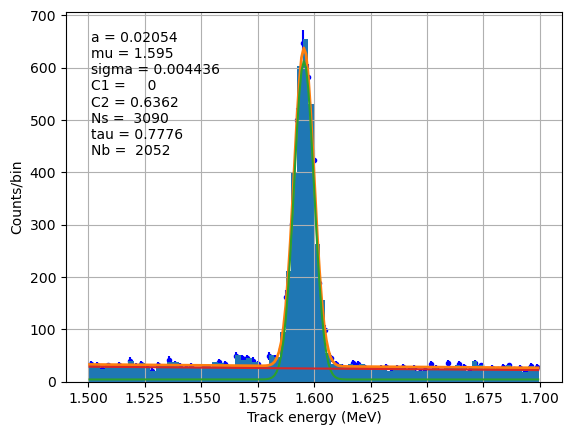

In [29]:
# plot output
heights, bins, _ = plt.hist(e_tracks, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_sb.show(bins=binning+1, parts=True)
plt.show()

In [74]:
display(m_sb.params)
print(m_sb.params[0][1], m_sb.params[0][2])
print(len(m.params)+1)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.021,0.028,,,,,
1,mu,1.595,0.016,,,,,yes
2,sigma,4.44e-3,0.04e-3,,,,,yes
3,C1,0.0,0.1,,,,,yes
4,C2,0.636,0.006,,,,,yes
5,Ns,3.09e3,0.06e3,,,,,
6,tau,0.74,0.23,,,,,
7,Nb,2.04e3,0.05e3,,,,,


a 0.02053640229638344
7


In [52]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = value
    #dict[key].append(value)

# pull out the relevant values
fit_params = {}
[add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

[None, None, None, None, None, None, None, None]

In [56]:
# collect the fom stuff
#ns0 = quad(func.sig_func, fit_range[0], fit_range[1], args = (fit_params['Ns'],fit_params['a'], mu, sigma, C1, C2))#/bin_width
#nb0 = quad(func.bck_func, fit_range[0], fit_range[1], args = (fit_params['Nb'], fit_params['tau']))#/bin_width

print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(cut_tracks[0].index)))

Signal events: 3089.642561895908
Background events: 2043.4841044096916
Total Events by addition: 5133.126666305599
Total Events by row counting: 5131


In [101]:
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []

ns0 = fit_params['Ns']
nb0 = fit_params['Nb']
ns_l.append(fit_params['Ns'])
nb_l.append(fit_params['Nb'])


In [102]:
print(ns_l)
print(nb_l)

[3089.642561895908]
[2043.4841044096916]


### now to create the loop, and collect the gaussian and the full fit on repeat (this takes ages)

In [106]:
#del lh_g
#del m_g 
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []


def gaussian_fit(data, plot = False):
    '''
    Fit gaussian to the data
    '''
    blob_np = data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
    
    # minimise it
    m_g.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_data, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']


    return (mu, sigma)


def sb_fit(data, mu, sigma, C1, C2, plot = False):
    '''
    Fit signal and background to data
    '''
    blob_np = data['energy'].to_numpy()
    # create signal background pdf
    pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [len(blob_np)/2, len(blob_np)/2, 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True)

    # minimise that mfer
    m_sb.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    return (fit_params['Ns'], fit_params['Nb'])



Blob cut: 0.0 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


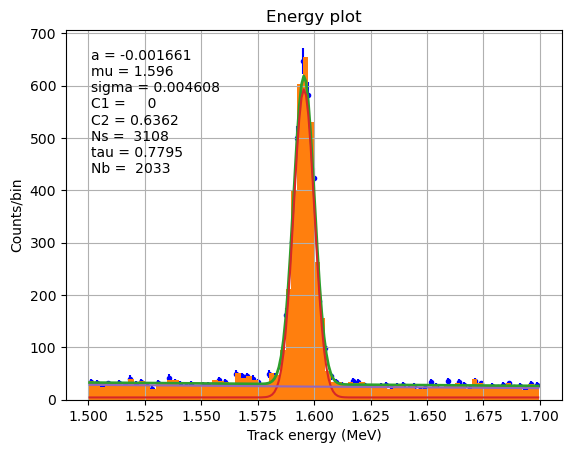

Signal events: 3107.8574708482674
Background events: 2025.0436441984436
Total Events by addition: 5132.901115046711
Total Events by row counting: 5131


Blob cut: 0.01 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


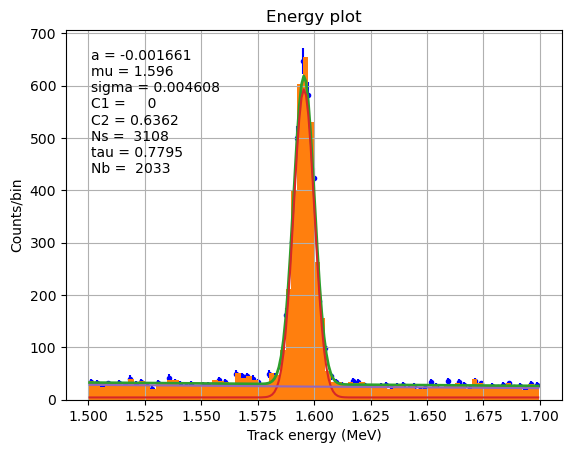

Signal events: 3107.8574708482674
Background events: 2025.0436441984436
Total Events by addition: 5132.901115046711
Total Events by row counting: 5131


Blob cut: 0.02 MeV
Mu fit completed, with values:
mu: 1.595504600275164
sigma: 0.004626785828026376


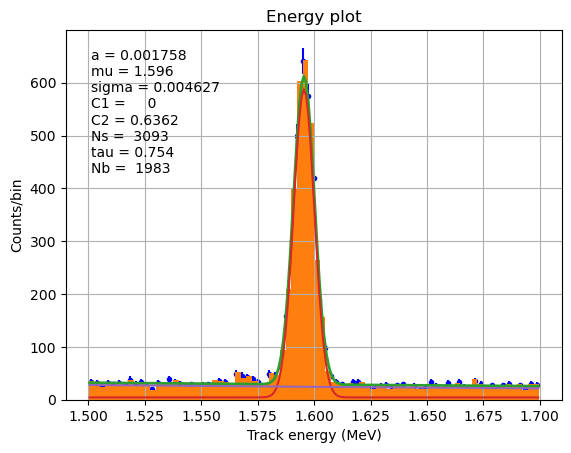

Signal events: 3093.063908524211
Background events: 1974.8724216755954
Total Events by addition: 5067.936330199806
Total Events by row counting: 5066


Blob cut: 0.03 MeV
Mu fit completed, with values:
mu: 1.5955110044119565
sigma: 0.004626037628055603


RuntimeError: exception was raised in user function
User function arguments:
        a = +0.006029
       mu = +1.595511
    sigma = +0.004626
       C1 = +0.000000
       C2 = +0.636206
       Ns = +2844.395461
      tau = +0.681530
       Nb = +1878.447613


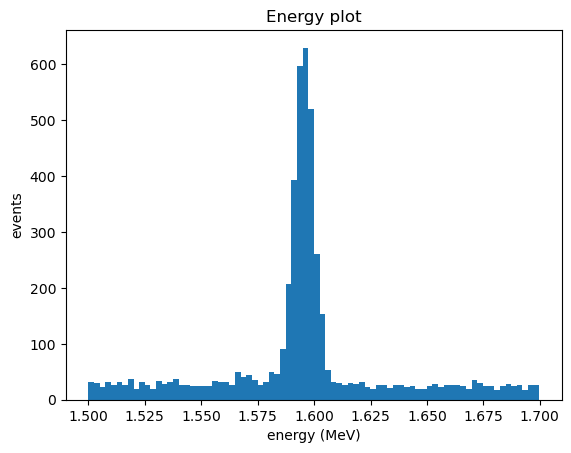

In [107]:
for i in range(len(cut_list)):
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    print("")
    print("")
    print("====================================")
    print("Blob cut: {} MeV".format(cut_list[i]))
    print("====================================")
    # fit gaussian for mu and sigma    
    #holder = gaussian_fit(blob_data)
    #mu = holder[0]
    #sigma = holder[1]

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']
    binning = 80
    g_popt, g_pcov = func.histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("Mu fit completed, with values:\nmu: {}\nsigma: {}".format(mu,sigma))
    holder_sb = sb_fit(blob_data, mu, sigma, C1, C2, plot = True)

    ns_l.append(holder_sb[0])
    nb_l.append(holder_sb[1])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)))
    
    # efficiency and background rej
    e_check = ns_l[i]/ns_l[0]
    b_check = nb_l[i]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
    b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data, mu, sigma, g_popt, g_pcov, holder_sb

    print("====================================")

In [80]:
for i in range(len(cut_list)):
    try:
        del lh_sb, vals_sb, nm_sb, m_sb, m_g, lh_g,
    except:
        pass
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    blob_np = blob_data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1),  print_level = 2)
    
    # minimise it
    m_g.migrad()

    print("Finished fitting gaussian")
    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_data, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']

    # now do full fit
    try:
        del lh_sb, vals_sb, nm_sb, m_sb
    except:
        pass
    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [fit_params['Ng'], len(blob_np) - fit_params['Ng'], 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)

    # minimise that mfer
    m_sb.migrad()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    ns_l.append(fit_params['Ns'])
    nb_l.append(fit_params['Nb'])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(blob_data[0].index)))

    # efficiency and background rej
    e_check = fit_params['Ns']/ns_l[0]
    b_check = fit_params['Nb']/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns[i],ns[0],np.sqrt(ns[i]),np.sqrt(ns[0])))
    b_err.append(func.ratio_error(b[i],nb[i],nb[0],np.sqrt(nb[i]),np.sqrt(nb[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data

/tmp/ipykernel_12999/1455779925.py:15: InitialParamWarning: Parameter a does not have neither initial value nor limits.
  m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)),
/tmp/ipykernel_12999/1455779925.py:15: InitialParamWarning: Parameter C1 does not have neither initial value nor limits.
  m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)),
/tmp/ipykernel_12999/1455779925.py:15: InitialParamWarning: Parameter C2 does not have neither initial value nor limits.
  m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)),
Traceback (most recent call last):
  File "/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1396, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/s

Unexpected exception formatting exception. Falling back to standard exception


RuntimeError: exception was raised in user function
User function arguments:
        a = -0.003725
       mu = +1.580000
    sigma = +0.004000
       C1 = -0.000028
       C2 = -0.000325
       Ng = +5131.000000
Original python exception in user function:
ZeroDivisionError: float division
  File "probfit/costfunc.pyx", line 214, in probfit.costfunc.UnbinnedLH.__call__
  File "probfit/_libstat.pyx", line 169, in probfit._libstat.compute_nll
  File "probfit/functor.pyx", line 227, in probfit.functor.Extended.__call__
  File "probfit/functor.pyx", line 676, in probfit.functor.Normalized.__call__


In [91]:
'''
e_s2 = np.append(e_s, e_s2)
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s2, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s2, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s2), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s2), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m2 = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

In [92]:
'''
# minimise that mfer
m2.migrad()
heights, bins, _ = plt.hist(e_s2, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)
plt.show()
'''

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   0 - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   1 - FCN =  -103883.8363617 Edm =      6118.56 NCalls =    119
VariableMetric: Iteration #   2 - FCN =  -108560.6179698 Edm =       914.85 NCalls =    143
VariableMetric: Iteration #   3 - FCN =  -108715.0329486 Edm =      451.082 NCalls =    159
VariableMetric: Iteration #   4 - FCN =  -108822.0763603 Edm =      29.2179 NCalls =    173
VariableMetric: Iteration #   5 - FCN =  -108830.6308968 Edm =      14.9261 NCalls =    187
VariableMetric: Iteration #   6 - FCN =  -108842.8533993 Edm =      4.13233 NCalls =    201
VariableMetric: Iteration #   7 - FCN =  -108850.6622825 Edm =      1.94108 NCalls =    215
VariableMetric: Iteration #   8 - FCN =  -108871.5466668 Edm =      10.4149 NCalls =    233
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.089e+05                 │        Nfcn = 376 (376 total)        │
│ EDM = 2.87e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.49    │   0.28    │            │            │         │         │       │
│ 1 │ mu    │  1.5939   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.73e-3  │  0.31e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.361   │   0.023   │            │            │    0    │         │       │
│ 4 │ C2    │   0.297   │   0.020   │            │            │    0    │         │       │
│ 5 │ Ns    │  9.39e3   │  0.10e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘